In [33]:
# =========================
# 🔧 PARAMETERS (edit me!)
# =========================
DATA_DIR = "."                   # folder where your CSVs are (e.g., ".", "/content", or "./sample_data")
PFC_FILE = "PFC1.csv"
HPC_FILE = "HPC1.csv"
EMG_FILE = "EMG1.csv"

CSV_HAS_HEADER = False           # set True if your CSVs have headers
CSV_VALUE_COL  = 0               # column name or index with the values

# Optional manual labels (comment/None if not available)
LABELS_FILE = None               # e.g., "manual_states.csv"
LABELS_COL  = 0
LABELS_KIND = "sample"           # "sample" or "window"

# Sampling & windowing
FS_HZ      = 256                 # set your true sampling rate
WINDOW_SEC = 5.0
STEP_SEC   = 2.5                 # 50% overlap

# Spectrogram (STFT)
N_PER_SEG   = 256
N_OVERLAP   = 192
FREQ_MAX_HZ = 125

# Autoencoder
LATENT_DIM   = 32
BATCH_SIZE   = 64
EPOCHS       = 15
LR           = 1e-3
WEIGHT_DECAY = 1e-5

# DBSCAN (tune EPS using the k-distance elbow)
DBSCAN_EPS       = 0.12          # start near your k-distance elbow
DBSCAN_MIN_SAMP  = 10

# 2D viz
USE_UMAP     = True              # if False -> TSNE
N_COMPONENTS = 2

# Device + reproducibility
import torch, random, numpy as np
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED   = 42

def set_seed(s=SEED):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)
DEVICE


'cpu'

In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import signal

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

try:
    import umap
    HAS_UMAP = True
except:
    HAS_UMAP = False


In [35]:
def load_signal_csv(path, has_header=False, col=0):
    if has_header:
        df = pd.read_csv(path)
        x = df[col].values
    else:
        df = pd.read_csv(path, header=None)
        x = df.iloc[:, col].values
    return np.asarray(x, dtype=np.float32)

data_dir = Path(DATA_DIR)

paths = [data_dir / PFC_FILE, data_dir / HPC_FILE, data_dir / EMG_FILE]
for p in paths:
    assert p.exists(), f"File not found: {p}. Check DATA_DIR and filenames."

pfc = load_signal_csv(paths[0], CSV_HAS_HEADER, CSV_VALUE_COL)
hpc = load_signal_csv(paths[1], CSV_HAS_HEADER, CSV_VALUE_COL)
emg = load_signal_csv(paths[2], CSV_HAS_HEADER, CSV_VALUE_COL)

min_len = min(len(pfc), len(hpc), len(emg))
pfc, hpc, emg = pfc[:min_len], hpc[:min_len], emg[:min_len]

# 🔴 No detrend, no z-score, no standardization — use as-is
signals = np.stack([pfc, hpc, emg], axis=0).astype(np.float32)  # (C, T)
signals.shape, signals.dtype


((3, 1342539), dtype('float32'))

In [36]:
WIN  = int(WINDOW_SEC * FS_HZ)
STEP = int(STEP_SEC * FS_HZ)

def make_windows(T, win, step):
    idx = []
    i = 0
    while i + win <= T:
        idx.append((i, i + win))
        i += step
    return idx

def channel_spectrogram(x_ch):
    f, t, Z = signal.stft(x_ch, fs=FS_HZ, nperseg=N_PER_SEG, noverlap=N_OVERLAP, boundary=None)
    keep = f <= FREQ_MAX_HZ
    S = np.abs(Z[keep, :])
    S = np.log1p(S)  # log scale (stable for CNN; still not "preprocessing" your raw values)
    return f[keep], t, S

T = signals.shape[1]
idx = make_windows(T, WIN, STEP)

specs = []
for (a, b) in idx:
    window_specs = []
    for c in range(signals.shape[0]):
        f, tt, S = channel_spectrogram(signals[c, a:b])
        window_specs.append(S)
    specs.append(np.stack(window_specs, axis=0))  # (C, F, T_spec)

specs = np.stack(specs, axis=0).astype(np.float32)  # (N, C, F, T_spec)
N, C, F_bins, T_bins = specs.shape
print(f"N_windows={N}, spec image shape per window={(C, F_bins, T_bins)}")


N_windows=2096, spec image shape per window=(3, 126, 17)


In [37]:
labels_win = None
if LABELS_FILE is not None:
    lab_path = data_dir / LABELS_FILE
    if CSV_HAS_HEADER:
        labs = pd.read_csv(lab_path)[LABELS_COL].values
    else:
        labs = pd.read_csv(lab_path, header=None).iloc[:, LABELS_COL].values
    labs = np.asarray(labs)

    if LABELS_KIND == "sample":
        window_labels = []
        for (a, b) in idx:
            seg = labs[a:b]
            if len(seg) == 0:
                window_labels.append(-1)
            else:
                vals, counts = np.unique(seg, return_counts=True)
                window_labels.append(vals[np.argmax(counts)])
        labels_win = np.array(window_labels)
    else:
        assert len(labs) == len(idx), "window labels length must equal #windows"
        labels_win = labs
print("labels_win:", None if labels_win is None else labels_win.shape)


labels_win: None


In [45]:
  class SpecDataset(Dataset):
      def __init__(self, arr): self.x = arr
      def __len__(self): return self.x.shape[0]
      def __getitem__(self, i): return torch.from_numpy(self.x[i])

  class ConvAE(nn.Module):
      def __init__(self, in_channels=3, latent_dim=32):
          super().__init__()
          self.enc = nn.Sequential(
              nn.Conv2d(in_channels, 16, 3, 2, 1), nn.ReLU(True),
              nn.Conv2d(16, 32, 3, 2, 1),          nn.ReLU(True),
              nn.Conv2d(32, 64, 3, 2, 1),          nn.ReLU(True),
          )
          # Calculate the output shape of the encoder dynamically
          with torch.no_grad():
              dummy = torch.zeros(1, in_channels, F_bins, T_bins)
              encoded_dummy = self.enc(dummy)
              self.encoded_shape = encoded_dummy.shape
          self.flat_dim = encoded_dummy.view(encoded_dummy.size(0), -1).shape[1]

          self.fc_mu = nn.Linear(self.flat_dim, latent_dim)
          self.fc_up = nn.Linear(latent_dim, self.flat_dim)

          self.dec = nn.Sequential(
              nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(True),
              nn.ConvTranspose2d(32, 16, 4, 2, 1), nn.ReLU(True),
              nn.ConvTranspose2d(16, in_channels, 4, 2, 1),
          )

      def encode(self, x):
          h = self.enc(x)
          h = h.view(h.size(0), -1)
          return self.fc_mu(h)

      def decode(self, z):
          # Reshape back to the shape of the encoder output before flattening
          # Use -1 for batch size, and the spatial dimensions from the stored encoded_shape
          h = self.fc_up(z).view(-1, self.encoded_shape[1], self.encoded_shape[2], self.encoded_shape[3])
          return self.dec(h)

      def forward(self, x):
          z = self.encode(x)
          x_hat = self.decode(z)
          return x_hat, z

  dataset = SpecDataset(specs)
  loader  = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

  model = ConvAE(in_channels=C, latent_dim=LATENT_DIM).to(DEVICE)
  opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
  loss_fn = nn.MSELoss()

Epoch 01/15  recon MSE: 0.6640
Epoch 02/15  recon MSE: 0.1687
Epoch 03/15  recon MSE: 0.1337
Epoch 04/15  recon MSE: 0.1177
Epoch 05/15  recon MSE: 0.1146
Epoch 06/15  recon MSE: 0.1132
Epoch 07/15  recon MSE: 0.1119
Epoch 08/15  recon MSE: 0.1108
Epoch 09/15  recon MSE: 0.1097
Epoch 10/15  recon MSE: 0.1087
Epoch 11/15  recon MSE: 0.1079
Epoch 12/15  recon MSE: 0.1071
Epoch 13/15  recon MSE: 0.1080
Epoch 14/15  recon MSE: 0.1091
Epoch 15/15  recon MSE: 0.1060


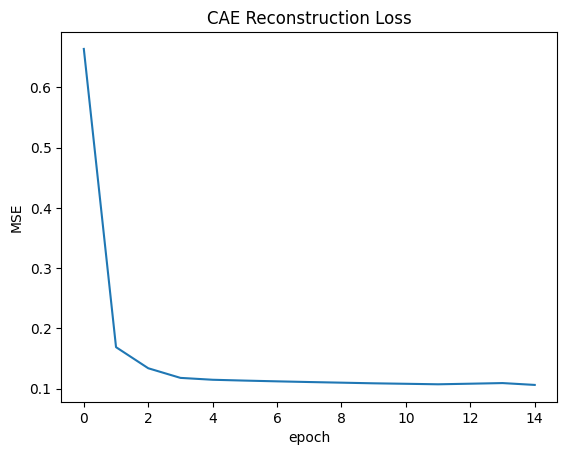

In [47]:
loss_hist = []
model.train()
for epoch in range(1, EPOCHS + 1):
    epoch_loss = 0.0
    for xb in loader:
        xb = xb.to(DEVICE, dtype=torch.float32)
        opt.zero_grad()
        x_hat, z = model(xb)
        x_hat = x_hat[..., :xb.shape[2], :xb.shape[3]]

        loss = loss_fn(x_hat, xb)
        loss.backward()
        opt.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(dataset)
    loss_hist.append(epoch_loss)
    print(f"Epoch {epoch:02d}/{EPOCHS}  recon MSE: {epoch_loss:.4f}")

plt.figure(); plt.plot(loss_hist); plt.title("CAE Reconstruction Loss"); plt.xlabel("epoch"); plt.ylabel("MSE"); plt.show()


In [49]:
model.eval()
Z = []
with torch.no_grad():
    for xb in DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False):
        xb = xb.to(DEVICE, dtype=torch.float32)
        Z.append(model.encode(xb).cpu().numpy())
Z = np.concatenate(Z, axis=0)  # (N, LATENT_DIM)
print("Z shape:", Z.shape)


Z shape: (2096, 32)


Explained var (first 10): [0.177 0.047 0.044 0.042 0.039 0.037 0.035 0.033 0.033 0.032]


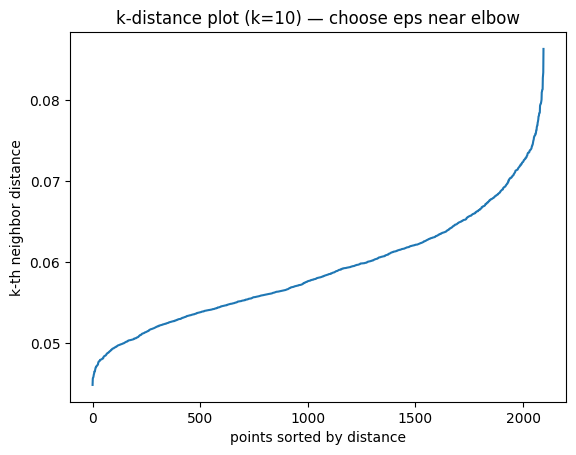

In [50]:
pca = PCA(n_components=min(50, Z.shape[1]))
Z50 = pca.fit_transform(Z)
print("Explained var (first 10):", np.round(pca.explained_variance_ratio_[:10], 3))

k = max(DBSCAN_MIN_SAMP, 2)
nn = NearestNeighbors(n_neighbors=k).fit(Z50)
dists, _ = nn.kneighbors(Z50)
k_dists = np.sort(dists[:, -1])

plt.figure(); plt.plot(k_dists)
plt.title(f"k-distance plot (k={k}) — choose eps near elbow")
plt.xlabel("points sorted by distance"); plt.ylabel("k-th neighbor distance"); plt.show()


In [51]:
db = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMP).fit(Z50)
cl = db.labels_
n_noise    = int(np.sum(cl == -1))
n_clusters = len(set(cl)) - (1 if -1 in cl else 0)
print(f"DBSCAN -> clusters={n_clusters}, noise={n_noise}")


DBSCAN -> clusters=1, noise=0


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


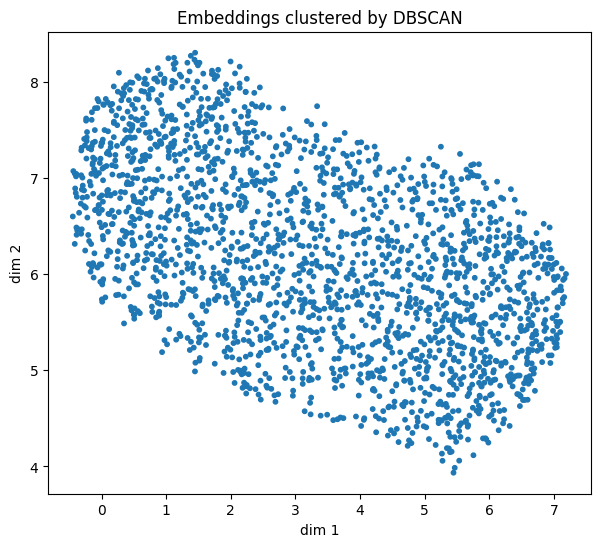

In [52]:
if USE_UMAP and HAS_UMAP:
    reducer = umap.UMAP(n_components=N_COMPONENTS, random_state=SEED)
    Z2 = reducer.fit_transform(Z50)
else:
    Z2 = TSNE(n_components=N_COMPONENTS, random_state=SEED, perplexity=30, init="pca").fit_transform(Z50)

plt.figure(figsize=(7,6))
plt.scatter(Z2[:,0], Z2[:,1], s=10, c=cl, cmap="tab20")
plt.title("Embeddings clustered by DBSCAN"); plt.xlabel("dim 1"); plt.ylabel("dim 2"); plt.show()

if labels_win is not None:
    plt.figure(figsize=(7,6))
    plt.scatter(Z2[:,0], Z2[:,1], s=10, c=labels_win, cmap="tab10")
    plt.title("Embeddings colored by manual 4 states"); plt.xlabel("dim 1"); plt.ylabel("dim 2"); plt.show()


In [53]:
def plot_cluster_examples(cluster_id, max_examples=6):
    idxs = np.where(cl == cluster_id)[0]
    if len(idxs) == 0:
        print("No windows in cluster", cluster_id); return
    n = min(max_examples, len(idxs))
    fig = plt.figure(figsize=(12, 2.2*n))
    for i, k in enumerate(idxs[:n]):
        ax = plt.subplot(n, 1, i+1)
        img = specs[k].sum(axis=0)  # sum channels just for display
        ax.imshow(img, aspect='auto', origin='lower')
        ax.set_title(f"Cluster {cluster_id} — example {i+1}")
        ax.set_xlabel("time bins"); ax.set_ylabel("freq bins")
    plt.tight_layout(); plt.show()

print("Use: plot_cluster_examples(cluster_id)")


Use: plot_cluster_examples(cluster_id)


In [54]:
meta = pd.DataFrame({
    "win_idx": np.arange(N),
    "start_sample": [a for (a, b) in idx],
    "end_sample":   [b for (a, b) in idx],
    "cluster": cl
})
if labels_win is not None:
    meta["manual_state"] = labels_win

meta.head()    # meta.to_csv("window_metadata.csv", index=False)


,win_idx,start_sample,end_sample,cluster
0,0,0,1280,0
1,1,640,1920,0
2,2,1280,2560,0
3,3,1920,3200,0
4,4,2560,3840,0


In [31]:
def plot_cluster_examples(cluster_id, max_examples=6):
    idxs = np.where(cl == cluster_id)[0]
    if len(idxs) == 0:
        print("No windows in cluster", cluster_id); return
    n = min(max_examples, len(idxs))
    fig = plt.figure(figsize=(12, 2.2*n))
    for i, k in enumerate(idxs[:n]):
        ax = plt.subplot(n, 1, i+1)
        img = specs[k]  # (C,F,T)
        # simple visualization: sum across channels for compactness
        show = img.sum(axis=0)
        im = ax.imshow(show, aspect='auto', origin='lower')
        ax.set_title(f"Cluster {cluster_id} — example {i+1}")
        ax.set_xlabel("time bins"); ax.set_ylabel("freq bins")
    plt.tight_layout()
    plt.show()

print("Use: plot_cluster_examples(cluster_id) to browse cluster exemplars.")


Use: plot_cluster_examples(cluster_id) to browse cluster exemplars.


In [32]:
# Export per-window metadata for further analysis / review
meta = pd.DataFrame({
    "win_idx": np.arange(N),
    "start_sample": [a for (a, b) in idx],
    "end_sample":   [b for (a, b) in idx],
    "cluster": cl
})
if labels_win is not None:
    meta["manual_state"] = labels_win

# meta.to_csv("window_metadata.csv", index=False)
meta.head()


,win_idx,start_sample,end_sample,cluster
0,0,0,1280,0
1,1,640,1920,0
2,2,1280,2560,0
3,3,1920,3200,0
4,4,2560,3840,0
